In [1]:
# importing necessary libraries
import os
import time
import copy
import numpy as np
import pandas as pd
from PIL import Image
import torch,torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from torch.nn import Parameter

In [2]:
from collections.abc import Iterable

def set_freeze_by_idxs(model, idxs, freeze=True): 
    """ Function to freeze layers of model during fine-training"""
    if not isinstance(idxs, Iterable):
        idxs = [idxs]
    num_child = len(list(model.children()))
    idxs = tuple(map(lambda idx: num_child + idx if idx < 0 else idx, idxs))
    for idx, child in enumerate(model.children()):
        if idx not in idxs:
            continue
        for param in child.parameters():
            param.requires_grad = not freeze
    return model
            
def freeze_by_idxs(model, idxs):
    return set_freeze_by_idxs(model, idxs, True)

def unfreeze_by_idxs(model, idxs):
    return set_freeze_by_idxs(model, idxs, False)

def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad=False
    return model

def initialize_model(model_name, num_classes, use_pretrained, unfreeze_num):
    """Function to intialize various model ['vgg16','vgg19','resnet50','resnet101','resnet152','densenet161','densenet201']
        and modify output classifier layers according to number of classes, with "unfreeze_num" of layers freezed.
    """
    if model_name=='vgg16':
        model_pre=models.vgg16(pretrained=use_pretrained) 
        model_pre.features[0].in_channels=1
        model_pre.features[0].weight=Parameter(model_pre.features[0].weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre) 
        num_ftrs=model_pre.classifier[6].in_features # feature_map 
        model_pre.classifier[6]=nn.Linear(num_ftrs,num_classes) 
        if unfreeze_num==1:
            unfreeze=[-1]
        elif unfreeze_num==2:
            unfreeze=[-1,-3]
        elif unfreeze_num==3:
            unfreeze=[-1,-3,-5]
        else:
            unfreeze=[-1,-3,-5,-7]
        model_pre.features=unfreeze_by_idxs(model_pre.features,unfreeze)
        for param in model_pre.classifier.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='vgg19':
        model_pre=models.vgg19(pretrained=use_pretrained) 
        model_pre.features[0].in_channels=1
        model_pre.features[0].weight=Parameter(model_pre.features[0].weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre) 
        num_ftrs=model_pre.classifier[6].in_features
        model_pre.classifier[6]=nn.Linear(num_ftrs,num_classes) 
        if unfreeze_num==1:
            unfreeze=[-1]
        elif unfreeze_num==2:
            unfreeze=[-1,-3]
        elif unfreeze_num==3:
            unfreeze=[-1,-3,-5]
        else:
            unfreeze=[-1,-3,-5,-7]
        model_pre.features=unfreeze_by_idxs(model_pre.features,unfreeze)
        for param in model_pre.classifier.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='resnet101':
        model_pre=models.resnet101(pretrained=use_pretrained) 
        model_pre.conv1.in_channels=1
        model_pre.conv1.weight=Parameter(model_pre.conv1.weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.fc.in_features 
        model_pre.fc=nn.Linear(num_ftrs,num_classes)
        
        for i in range(unfreeze_num):
            model_pre.layer4=unfreeze_by_idxs(model_pre.layer4,-i)
        for param in model_pre.fc.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='resnet50':
        model_pre=models.resnet50(pretrained=use_pretrained) 
        model_pre.conv1.in_channels=1
        model_pre.conv1.weight=Parameter(model_pre.conv1.weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.fc.in_features
        model_pre.fc=nn.Linear(num_ftrs,num_classes)

        for i in range(unfreeze_num):
            model_pre.layer4=unfreeze_by_idxs(model_pre.layer4,-i)
        for param in model_pre.fc.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='resnet152':
        model_pre=models.resnet152(pretrained=use_pretrained) 
        model_pre.conv1.in_channels=1
        model_pre.conv1.weight=Parameter(model_pre.conv1.weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.fc.in_features
        model_pre.fc=nn.Linear(num_ftrs,num_classes)

        for i in range(unfreeze_num):
            model_pre.layer4=unfreeze_by_idxs(model_pre.layer4,-i)
        for param in model_pre.fc.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='densenet121':
        model_pre=models.densenet121(pretrained=use_pretrained)
        model_pre.features[0].in_channels=1
        model_pre.features[0].weight=Parameter(model_pre.features[0].weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.classifier.in_features 
        model_pre.classifier=nn.Linear(num_ftrs,num_classes)
        for i in range(unfreeze_num):
            model_pre.features.denseblock4=unfreeze_by_idxs(model_pre.features.denseblock4,-i)
        for param in model_pre.classifier.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='densenet161':
        model_pre=models.densenet161(pretrained=use_pretrained)
        model_pre.features[0].in_channels=1
        model_pre.features[0].weight=Parameter(model_pre.features[0].weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.classifier.in_features 
        model_pre.classifier=nn.Linear(num_ftrs,num_classes)
        for i in range(unfreeze_num):
            model_pre.features.denseblock4=unfreeze_by_idxs(model_pre.features.denseblock4,-i)
        for param in model_pre.classifier.parameters():
            param.requires_grad=True
        input_size=224
    elif model_name=='densenet201':
        model_pre=models.densenet201(pretrained=use_pretrained)
        model_pre.features[0].in_channels=1
        model_pre.features[0].weight=Parameter(model_pre.features[0].weight[:,1:2,:,:])
        model_pre=set_parameter_requires_grad(model_pre)
        num_ftrs=model_pre.classifier.in_features 
        model_pre.classifier=nn.Linear(num_ftrs,num_classes)
        for i in range(unfreeze_num):
            model_pre.features.denseblock4=unfreeze_by_idxs(model_pre.features.denseblock4,-i)
        for param in model_pre.classifier.parameters():
            param.requires_grad=True
        input_size=224
    else:
        print('model not implemented')
        return None,None
    return model_pre, input_size

def auto_net(model_name, num_classes, use_pretrained, unfreeze_num):
    """ Function to prepare model using "initialize_model" method and saving their models with weights.
        saved weights will be saved at '/{model_name}/{model_name}_{unfeeze_num}.pth'"""
    model_all = []
    for k in range(unfreeze_num):
        model, input_size = initialize_model(model_name, num_classes, use_pretrained, k+1)
        my_path = Path(dir + '/{}'.format(model_name))
        if not my_path.is_dir():    
            os.mkdir(my_path)
        torch.save(model, dir + '/{}/{}_{}.pth'.format(model_name, model_name, k)) 
        model_all.append(model)
    return model_all

In [3]:
from pathlib import Path

model_all = []
dir = '.'

model_names = ['vgg16','vgg19', 'resnet50', 'resnet101','resnet152','densenet121', 'densenet161','densenet201'] 

# using 'densenet201' as our model
# can experiment with other models
model_all = auto_net(model_names[-1], num_classes=3, use_pretrained=True, unfreeze_num=4)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

In [4]:
# Data Preparation
# Training dataframe
train_df = pd.read_csv('../input/covidxct/train_COVIDx_CT-3A.txt', sep=" ", header=None)
train_df.columns=['filename', 'label', 'xmin','ymin','xmax','ymax']
train_df=train_df.drop(['xmin', 'ymin','xmax', 'ymax'], axis=1 )

# Validation dataframe
val_df = pd.read_csv('../input/covidxct/val_COVIDx_CT-3A.txt', sep=" ", header=None)
val_df.columns=['filename', 'label', 'xmin','ymin','xmax','ymax']
val_df=val_df.drop(['xmin', 'ymin','xmax', 'ymax'], axis=1 )

# Testing dataframe
test_df = pd.read_csv('../input/covidxct/test_COVIDx_CT-3A.txt', sep=" ", header=None)
test_df.columns=['filename', 'label', 'xmin','ymin','xmax','ymax']
test_df=test_df.drop(['xmin', 'ymin','xmax', 'ymax'], axis=1 )

In [5]:
train_df.label.value_counts()

2    294552
0     35996
1     26970
Name: label, dtype: int64

In [6]:
image_path = '../input/covidxct/3A_images/'  # directory path of images
train_df['filename'] = image_path + train_df['filename']
val_df['filename'] = image_path + val_df['filename']
test_df['filename'] = image_path + test_df['filename']

train_df.head()

,filename,label
0,../input/covidxct/3A_images/NCP_96_1328_0032.png,2
1,../input/covidxct/3A_images/NCP_96_1328_0035.png,2
2,../input/covidxct/3A_images/NCP_96_1328_0036.png,2
3,../input/covidxct/3A_images/NCP_96_1328_0037.png,2
4,../input/covidxct/3A_images/NCP_96_1328_0038.png,2


Balancing the training and validation datastets. 
Since pneumonia has minimum number of samples, we will undersample the Normal and Covid Scans to be equal to pneumonia scans.

In [7]:
N = train_df[train_df['label'] == 0]
P = train_df[train_df['label'] == 1]
C = train_df[train_df['label'] == 2]

from sklearn.utils import resample


min_cases = min([len(N), len(P), len(C)])
N_download = resample(N, replace = True, n_samples = min_cases, random_state=0)
C_download = resample(C, replace = True, n_samples = min_cases, random_state=0)
train_df = pd.concat([N_download, P, C_download])
train_df.label.value_counts()

0    26970
1    26970
2    26970
Name: label, dtype: int64

For validation set, we will resample pneumonia and normal cases to be equal to Covid scans.

In [8]:
N_v = val_df[val_df['label'] == 0]
P_v = val_df[val_df['label'] == 1]
C_v = val_df[val_df['label'] == 2]

from sklearn.utils import resample

min_cases_v = len(C_v)
N_v_download = resample(N_v, replace = True, n_samples = min_cases_v,random_state=0)
P_v_download = resample(P_v, replace = True, n_samples = min_cases_v,random_state=0)
val_df = pd.concat([N_v_download, P_v_download, C_v])

val_df.label.value_counts()

0    8147
1    8147
2    8147
Name: label, dtype: int64

In [9]:
train_df = shuffle(train_df) 
val_df = shuffle(val_df)
test_df = shuffle(test_df)

In [10]:
labels = {0:'Normal',1:'Pneumonia',2:'COVID-19'}
class_names = ['Normal','Pneumonia','COVID-19']

train_df['label_n'] = [labels[b] for b in train_df['label']]
val_df['label_n'] = [labels[b] for b in val_df['label']]
test_df['label_n'] = [labels[b] for b in test_df['label']]
train_df.head()

,filename,label,label_n
28733,../input/covidxct/3A_images/CP_2435_2903_0200.png,1,Pneumonia
90162,../input/covidxct/3A_images/NCP_3986_5492_0023...,2,COVID-19
8386,../input/covidxct/3A_images/NCP_2719_2675_0010...,2,COVID-19
83463,../input/covidxct/3A_images/CP_3718_5648_0120.png,1,Pneumonia
82388,../input/covidxct/3A_images/CP_1120_3338_0081.png,1,Pneumonia


In [11]:
print(f"Negative and positive values of train: \n{train_df['label_n'].value_counts()}")
print(f"Negative and positive values of validation: \n{val_df['label_n'].value_counts()}")
print(f"Negative and positive values of test: \n{test_df['label_n'].value_counts()}")

Negative and positive values of train: 
Pneumonia    26970
COVID-19     26970
Normal       26970
Name: label_n, dtype: int64
Negative and positive values of validation: 
Pneumonia    8147
COVID-19     8147
Normal       8147
Name: label_n, dtype: int64
Negative and positive values of test: 
Normal       17922
Pneumonia     7965
COVID-19      7894
Name: label_n, dtype: int64


In [12]:
train_df=train_df.reset_index()
val_df=val_df.reset_index()
test_df=test_df.reset_index()

In [13]:
class CovidDataset(Dataset):
    def __init__(self, dataset_df, transform=None):
        self.dataset_df = dataset_df
        self.transform = transform
        
    def set_transform(self, transform):
        self.transform = transform
        
    def __len__(self):
        return self.dataset_df.shape[0]
    
    def __getitem__(self, idx):
        image_name = self.dataset_df['filename'][idx]
        img = Image.open(image_name)
        label = self.dataset_df['label'][idx]
        
        if self.transform:
            img = self.transform(img)
        return img, label

In [14]:
# Training variables and hyperparamaters
batch_size = 64
input_channel = 1
input_size = (224,224)
crop_size = (340,380)
num_classes = 3

In [15]:
def batch_mean_and_std(loader):
    cnt = 0
    fst_moment = torch.empty(1)
    snd_moment = torch.empty(1)
    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images)
        sum_of_square = torch.sum(images ** 2)
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels
    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)        
    return mean,std

In [16]:
# Image transformations 
transform = transforms.Compose([
                transforms.CenterCrop(crop_size),
                transforms.Resize(input_size),
                transforms.Grayscale(input_channel),
                transforms.ToTensor()
                ])


train_dataset = DataLoader(CovidDataset(train_df, transform=transform), batch_size=batch_size, shuffle=True, num_workers=4)
val_dataset = DataLoader(CovidDataset(val_df, transform=transform), batch_size=batch_size, shuffle=True, num_workers=4)
test_dataset = DataLoader(CovidDataset(test_df, transform=transform), batch_size=batch_size, shuffle=True, num_workers=4)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:
train_mean, train_std = batch_mean_and_std(train_dataset)
val_mean, val_std = batch_mean_and_std(val_dataset)
test_mean, test_std = batch_mean_and_std(test_dataset)

In [18]:
train_mean, train_std = train_mean.item(), train_std.item()
val_mean, val_std = val_mean.item(), val_std.item()
test_mean, test_std = test_mean.item(), test_std.item()

In [19]:
print(train_mean)

0.6547352075576782


In [20]:
# Image transformations 
transform = {
    'train':transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5), # Image augmentations for training
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.CenterCrop(crop_size),
        transforms.Resize(input_size),
        transforms.Grayscale(input_channel),
        transforms.ToTensor(),
        transforms.Normalize([train_mean],[train_std])
    ]),
    'val':transforms.Compose([
        transforms.CenterCrop(crop_size),
        transforms.Resize(input_size),
        transforms.Grayscale(input_channel),
        transforms.ToTensor(),
        transforms.Normalize([val_mean],[val_std])
    ]),
    'test':transforms.Compose([
        transforms.CenterCrop(crop_size),
        transforms.Resize(input_size),
        transforms.Grayscale(input_channel),
        transforms.ToTensor(),
        transforms.Normalize([test_mean],[test_std])
    ])
}

In [21]:
dataset_names = ['train','val','test']
image_transforms = {'train':transform['train'], 'val':transform['test'],'test':transform['test']}

train_dataset = CovidDataset(train_df, transform=image_transforms['train'])
val_dataset = CovidDataset(val_df, transform=image_transforms['val'])
test_dataset = CovidDataset(test_df, transform=image_transforms['test'])

image_dataset = {'train':train_dataset, 'val':val_dataset,'test':test_dataset}

dataloaders = {x:DataLoader(image_dataset[x],batch_size=batch_size,shuffle=True,num_workers=4) for x in dataset_names}

dataset_sizes = {x:len(image_dataset[x]) for x in dataset_names}

print(dataset_sizes)

{'train': 80910, 'val': 24441, 'test': 33781}


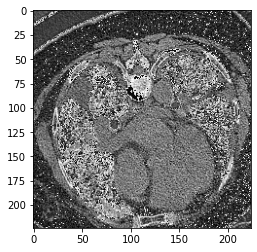

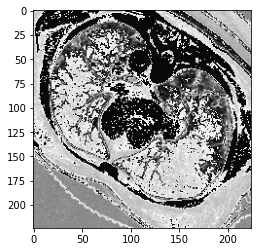

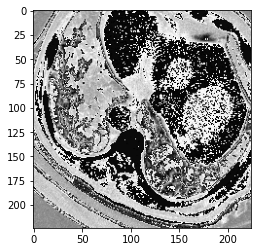

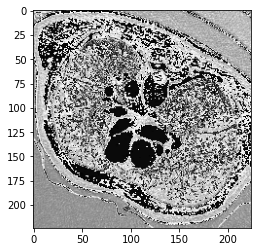

In [22]:
import matplotlib.pyplot as plt
from PIL import Image

def show_tensor_img(tensor_img):
    img=transforms.ToPILImage()(tensor_img)
    plt.figure()
    plt.imshow(img,plt.cm.gray)
    plt.show()

# Displaying some sample images from train dataset
for i in range(4):
    show_tensor_img(train_dataset[i][0])

In [23]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm=cm.numpy()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        cm=cm.astype('int')
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '{:.2f}' if normalize else '{}'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(i, j, fmt.format(cm[i, j]),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def confusion_matrix(preds, labels, conf_matrix):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        conf_matrix[t, p] += 1
    return conf_matrix

def calculate_all_prediction(conf_matrix):
    total_sum = conf_matrix.sum()
    correct_sum = (np.diag(conf_matrix)).sum()
    prediction = round(100*float(correct_sum)/float(total_sum),2)
    return prediction
 
def calculate_label_prediction(conf_matrix,labelidx):
    label_total_sum = conf_matrix.sum(axis=0)[labelidx]
    label_correct_sum = conf_matrix[labelidx][labelidx]
    prediction = 0
    if label_total_sum != 0:
        prediction = round(100*float(label_correct_sum)/float(label_total_sum),2)
    return prediction
 
def calculate_label_recall(conf_matrix,labelidx):
    label_total_sum = conf_matrix.sum(axis=1)[labelidx]
    label_correct_sum = conf_matrix[labelidx][labelidx]
    recall = 0
    if label_total_sum != 0:
        recall = round(100*float(label_correct_sum)/float(label_total_sum),2)
    return recall
 
def calculate_f1(prediction,recall):
    if (prediction+recall)==0:
        return 0
    return round(2*prediction*recall/(prediction+recall),2)

In [24]:
pretrained_model_path = './densenet201/densenet201_3.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = ['vgg16','vgg19', 'resnet50', 'resnet101','resnet152','densenet121', 'densenet161','densenet201'] 

# using densenet161 as our model
model = torch.load(pretrained_model_path)
model = model.to(device)

criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( model.parameters(), lr=0.0001,betas=(0.9, 0.999))

In [25]:
from tqdm import tqdm # for progess bar

def train(model, epoch, num_epochs, criterion,optimizer):
    model.train()
    print('-' * 100)
    #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    running_loss = 0.0
    running_corrects = 0
    with tqdm(dataloaders['train'], unit="batch") as tepoch:
        for idx, (inputs, labels) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs) 
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels) 

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc = torch.sum(preds == labels.data)/batch_size * 100.0
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            tepoch.set_postfix(loss=loss.item(), acc = acc)

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']
    print('train_total Loss: {:.4f} Acc: {:.4f}%'.format( epoch_loss, epoch_acc*100))

In [26]:
def validate(model,epoch,num_epochs,criterion,optimizer,best_acc):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    best_acc=best_acc
    best_model_wts=copy.deepcopy(model.state_dict())
    conf_matrix = torch.zeros(num_classes, num_classes) 
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders['val']):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            conf_matrix = confusion_matrix(outputs, labels, conf_matrix) 

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data) 

        plot_confusion_matrix(conf_matrix, classes=class_names, normalize=False, title='confusion matrix') 

    epoch_loss = running_loss / dataset_sizes['val'] 
    epoch_acc = running_corrects.double() / dataset_sizes['val'] 
    print('val_total Loss: {:.4f} Acc: {:.4f}%'.format( epoch_loss, epoch_acc*100))

    all_prediction = calculate_all_prediction(conf_matrix) 
    print('all_prediction:{}'.format(all_prediction))
    label_prediction = [] 
    label_recall = [] 
    for i in range(num_classes):
        label_prediction.append(calculate_label_prediction(conf_matrix,i))
        label_recall.append(calculate_label_recall(conf_matrix,i))

    keys=class_names
    values=list(range(num_classes))
    dictionary = dict(zip(keys, values))
    for ei,i in enumerate(dictionary):
        print(ei,'\t',i,'\t','prediction=',label_prediction[ei],'%,\trecall=',label_recall[ei],'%,\tf1=',calculate_f1(label_prediction[ei],label_recall[ei])) # 输出每个类的，精确率，召回率，F1
    p = round(np.array(label_prediction).sum()/len(label_prediction),2) 
    r = round(np.array(label_recall).sum()/len(label_prediction),2) 
    print('MACRO-averaged:\nprediction=',p,'%,recall=',r,'%,f1=',calculate_f1(p,r)) 

#     print(epoch_acc.tpye)
#     print(best_acc.type)
    if epoch_acc > best_acc:
        best_acc=epoch_acc.item()
        best_model_wts=copy.deepcopy(model.state_dict())

    return best_model_wts,best_acc,epoch_acc.item()

----------------------------------------------------------------------------------------------------


Epoch 0: 100%|██████████| 1265/1265 [07:41<00:00,  2.74batch/s, acc=tensor(21.8750, device='cuda:0'), loss=0.0103]


train_total Loss: 0.1868 Acc: 94.2702%
Confusion matrix, without normalization


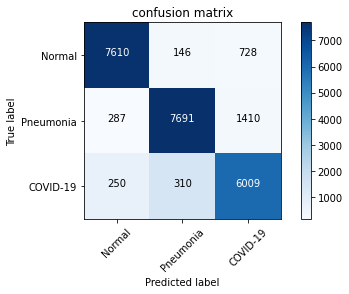

val_total Loss: 0.3673 Acc: 87.1896%
all_prediction:87.19
0 	 Normal 	 prediction= 89.7 %,	recall= 93.41 %,	f1= 91.52
1 	 Pneumonia 	 prediction= 81.92 %,	recall= 94.4 %,	f1= 87.72
2 	 COVID-19 	 prediction= 91.48 %,	recall= 73.76 %,	f1= 81.67
MACRO-averaged:
prediction= 87.7 %,recall= 87.19 %,f1= 87.44
----------------------------------------------------------------------------------------------------


Epoch 1: 100%|██████████| 1265/1265 [07:17<00:00,  2.89batch/s, acc=tensor(21.8750, device='cuda:0'), loss=0.0471]


train_total Loss: 0.0607 Acc: 98.0064%
Confusion matrix, without normalization


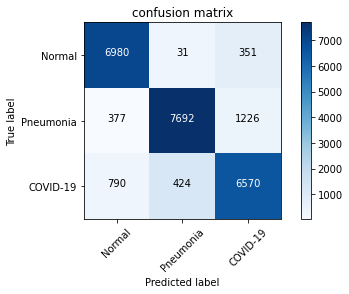

val_total Loss: 0.4317 Acc: 86.9113%
all_prediction:86.91
0 	 Normal 	 prediction= 94.81 %,	recall= 85.68 %,	f1= 90.01
1 	 Pneumonia 	 prediction= 82.75 %,	recall= 94.42 %,	f1= 88.2
2 	 COVID-19 	 prediction= 84.4 %,	recall= 80.64 %,	f1= 82.48
MACRO-averaged:
prediction= 87.32 %,recall= 86.91 %,f1= 87.11
----------------------------------------------------------------------------------------------------


Epoch 2: 100%|██████████| 1265/1265 [07:21<00:00,  2.86batch/s, acc=tensor(21.8750, device='cuda:0'), loss=0.041]


train_total Loss: 0.0421 Acc: 98.6813%
Confusion matrix, without normalization


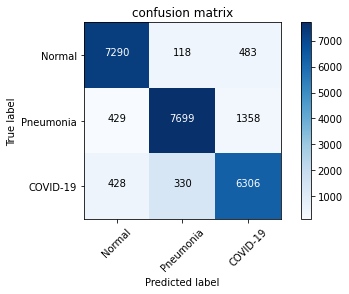

val_total Loss: 0.4107 Acc: 87.1282%
all_prediction:87.13
0 	 Normal 	 prediction= 92.38 %,	recall= 89.48 %,	f1= 90.91
1 	 Pneumonia 	 prediction= 81.16 %,	recall= 94.5 %,	f1= 87.32
2 	 COVID-19 	 prediction= 89.27 %,	recall= 77.4 %,	f1= 82.91
MACRO-averaged:
prediction= 87.6 %,recall= 87.13 %,f1= 87.36
----------------------------------------------------------------------------------------------------


Epoch 3: 100%|██████████| 1265/1265 [07:25<00:00,  2.84batch/s, acc=tensor(21.8750, device='cuda:0'), loss=0.0368]


train_total Loss: 0.0318 Acc: 98.9705%
Confusion matrix, without normalization


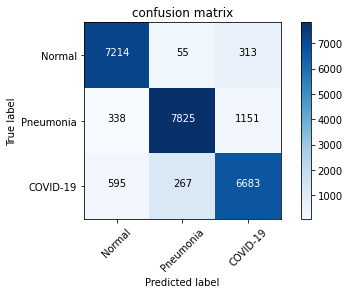

val_total Loss: 0.3687 Acc: 88.8753%
all_prediction:88.88
0 	 Normal 	 prediction= 95.15 %,	recall= 88.55 %,	f1= 91.73
1 	 Pneumonia 	 prediction= 84.01 %,	recall= 96.05 %,	f1= 89.63
2 	 COVID-19 	 prediction= 88.58 %,	recall= 82.03 %,	f1= 85.18
MACRO-averaged:
prediction= 89.25 %,recall= 88.88 %,f1= 89.06
----------------------------------------------------------------------------------------------------


Epoch 4: 100%|██████████| 1265/1265 [07:14<00:00,  2.91batch/s, acc=tensor(21.8750, device='cuda:0'), loss=0.0184]


train_total Loss: 0.0269 Acc: 99.1324%
Confusion matrix, without normalization


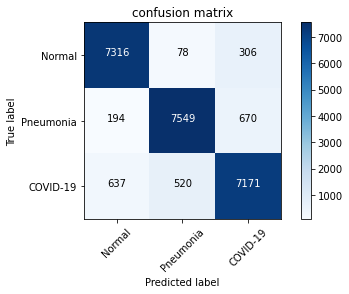

val_total Loss: 0.3236 Acc: 90.1600%
all_prediction:90.16
0 	 Normal 	 prediction= 95.01 %,	recall= 89.8 %,	f1= 92.33
1 	 Pneumonia 	 prediction= 89.73 %,	recall= 92.66 %,	f1= 91.17
2 	 COVID-19 	 prediction= 86.11 %,	recall= 88.02 %,	f1= 87.05
MACRO-averaged:
prediction= 90.28 %,recall= 90.16 %,f1= 90.22
----------------------------------------------------------------------------------------------------


Epoch 5: 100%|██████████| 1265/1265 [07:11<00:00,  2.93batch/s, acc=tensor(21.8750, device='cuda:0'), loss=0.0101]


train_total Loss: 0.0232 Acc: 99.2374%
Confusion matrix, without normalization


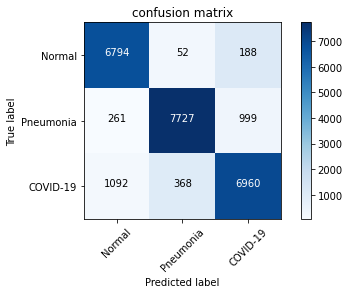

val_total Loss: 0.4411 Acc: 87.8892%
all_prediction:87.89
0 	 Normal 	 prediction= 96.59 %,	recall= 83.39 %,	f1= 89.51
1 	 Pneumonia 	 prediction= 85.98 %,	recall= 94.84 %,	f1= 90.19
2 	 COVID-19 	 prediction= 82.66 %,	recall= 85.43 %,	f1= 84.02
MACRO-averaged:
prediction= 88.41 %,recall= 87.89 %,f1= 88.15
----------------------------------------------------------------------------------------------------


Epoch 6: 100%|██████████| 1265/1265 [07:16<00:00,  2.90batch/s, acc=tensor(21.8750, device='cuda:0'), loss=0.0171]


train_total Loss: 0.0205 Acc: 99.3511%
Confusion matrix, without normalization


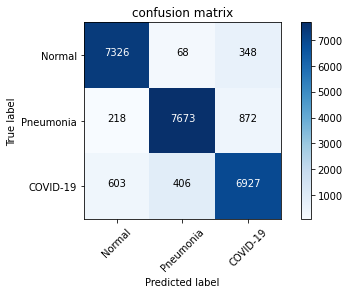

val_total Loss: 0.3789 Acc: 89.7099%
all_prediction:89.71
0 	 Normal 	 prediction= 94.63 %,	recall= 89.92 %,	f1= 92.21
1 	 Pneumonia 	 prediction= 87.56 %,	recall= 94.18 %,	f1= 90.75
2 	 COVID-19 	 prediction= 87.29 %,	recall= 85.03 %,	f1= 86.15
MACRO-averaged:
prediction= 89.83 %,recall= 89.71 %,f1= 89.77
----------------------------------------------------------------------------------------------------


Epoch 7: 100%|██████████| 1265/1265 [07:06<00:00,  2.97batch/s, acc=tensor(21.8750, device='cuda:0'), loss=0.0198]


train_total Loss: 0.0180 Acc: 99.4376%
Confusion matrix, without normalization


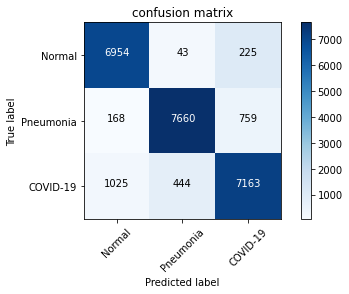

val_total Loss: 0.4764 Acc: 89.1003%
all_prediction:89.1
0 	 Normal 	 prediction= 96.29 %,	recall= 85.36 %,	f1= 90.5
1 	 Pneumonia 	 prediction= 89.2 %,	recall= 94.02 %,	f1= 91.55
2 	 COVID-19 	 prediction= 82.98 %,	recall= 87.92 %,	f1= 85.38
MACRO-averaged:
prediction= 89.49 %,recall= 89.1 %,f1= 89.29
----------------------------------------------------------------------------------------------------


Epoch 8: 100%|██████████| 1265/1265 [06:56<00:00,  3.04batch/s, acc=tensor(21.8750, device='cuda:0'), loss=0.00696]


train_total Loss: 0.0163 Acc: 99.4735%
Confusion matrix, without normalization


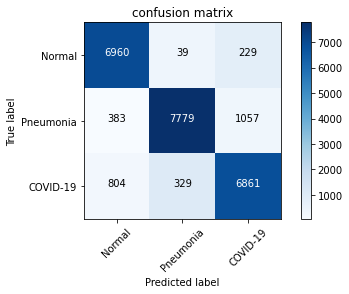

val_total Loss: 0.4855 Acc: 88.3761%
all_prediction:88.38
0 	 Normal 	 prediction= 96.29 %,	recall= 85.43 %,	f1= 90.54
1 	 Pneumonia 	 prediction= 84.38 %,	recall= 95.48 %,	f1= 89.59
2 	 COVID-19 	 prediction= 85.83 %,	recall= 84.22 %,	f1= 85.02
MACRO-averaged:
prediction= 88.83 %,recall= 88.38 %,f1= 88.6
----------------------------------------------------------------------------------------------------


Epoch 9: 100%|██████████| 1265/1265 [06:54<00:00,  3.05batch/s, acc=tensor(21.8750, device='cuda:0'), loss=0.00282]


train_total Loss: 0.0138 Acc: 99.5538%
Confusion matrix, without normalization


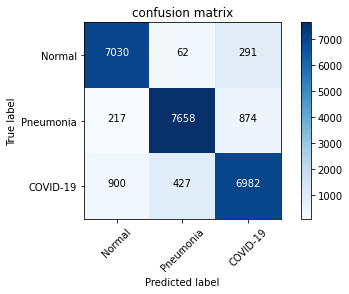

val_total Loss: 0.4495 Acc: 88.6625%
all_prediction:88.66
0 	 Normal 	 prediction= 95.22 %,	recall= 86.29 %,	f1= 90.54
1 	 Pneumonia 	 prediction= 87.53 %,	recall= 94.0 %,	f1= 90.65
2 	 COVID-19 	 prediction= 84.03 %,	recall= 85.7 %,	f1= 84.86
MACRO-averaged:
prediction= 88.93 %,recall= 88.66 %,f1= 88.79
****************************************************************************************************
best_acc:0.9015997708768053
****************************************************************************************************


In [27]:
import copy

num_epochs = 10

if __name__ == '__main__':
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    acc=[]
    for epoch in range(num_epochs):
        train(model,epoch,num_epochs,criterion,optimizer)
        best_model_wts,best_acc,epoch_acc=validate(model, epoch, num_epochs, criterion, optimizer, best_acc)
        acc.append(epoch_acc)
    print('*' * 100)
    print('best_acc:{}'.format(best_acc))
    print('*' * 100)
    torch.save(best_model_wts, 'densenet201_3_model_best_acc.pth')

In [28]:
print(acc)

[0.8718955852870177, 0.8691133750664867, 0.8712818624442535, 0.8887525060349413, 0.9015997708768053, 0.8788920256945296, 0.8970991366965345, 0.8910028231250767, 0.8837608935804591, 0.8866249335133587]


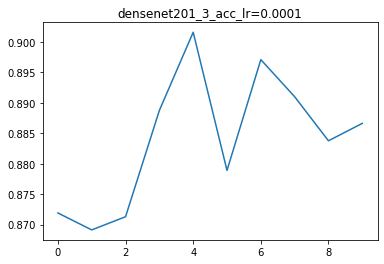

In [29]:
x=range(len(acc))
y=acc
plt.figure()
plt.title('densenet201_3_acc_lr=0.0001')
plt.plot(x,y)
plt.savefig('mini64_lr0.0001_e20_densenet201_3_acc.jpg')
plt.show()

In [30]:
def test(model,epoch,num_epochs,criterion,optimizer,best_acc):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    best_model_wts=copy.deepcopy(model.state_dict())
    conf_matrix = torch.zeros(num_classes, num_classes) 
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders['test']):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            conf_matrix = confusion_matrix(outputs, labels, conf_matrix) 

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data) 

        plot_confusion_matrix(conf_matrix, classes=class_names, normalize=False, title='confusion matrix') 

    epoch_loss = running_loss / dataset_sizes['test'] 
    epoch_acc = running_corrects.double() / dataset_sizes['test'] 
    print('test_total Loss: {:.4f} Acc: {:.4f}%'.format( epoch_loss, epoch_acc*100))

    all_prediction = calculate_all_prediction(conf_matrix) 
    print('all_prediction:{}'.format(all_prediction))
    label_prediction = [] 
    label_recall = [] 
    for i in range(num_classes):
        label_prediction.append(calculate_label_prediction(conf_matrix,i))
        label_recall.append(calculate_label_recall(conf_matrix,i))

    keys=class_names
    values=list(range(num_classes))
    dictionary = dict(zip(keys, values))
    for ei,i in enumerate(dictionary):
        print(ei,'\t',i,'\t','prediction=',label_prediction[ei],'%,\trecall=',label_recall[ei],'%,\tf1=',calculate_f1(label_prediction[ei],label_recall[ei])) # 输出每个类的，精确率，召回率，F1
    p = round(np.array(label_prediction).sum()/len(label_prediction),2) 
    r = round(np.array(label_recall).sum()/len(label_prediction),2) 
    print('MACRO-averaged:\nprediction=',p,'%,recall=',r,'%,f1=',calculate_f1(p,r)) 

    return epoch_acc.item()

Confusion matrix, without normalization


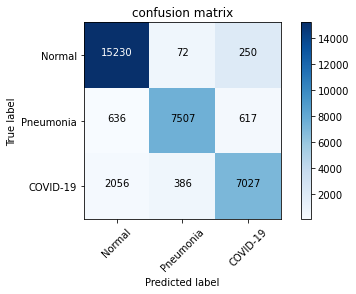

test_total Loss: 0.4110 Acc: 88.1087%
all_prediction:88.11
0 	 Normal 	 prediction= 97.93 %,	recall= 84.98 %,	f1= 91.0
1 	 Pneumonia 	 prediction= 85.7 %,	recall= 94.25 %,	f1= 89.77
2 	 COVID-19 	 prediction= 74.21 %,	recall= 89.02 %,	f1= 80.94
MACRO-averaged:
prediction= 85.95 %,recall= 89.42 %,f1= 87.65


In [31]:
best_model = "./densenet201_3_model_best_acc.pth"
epoch_acc=test(model, epoch, num_epochs, criterion, optimizer, best_acc)
